In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fraud_mock_df = pd.read_csv("../data/fraud_mock.csv")

In [3]:
fraud_transactions = fraud_mock_df[fraud_mock_df['is_fraud'] == 1]

# Overview

ดูภาพรวมของข้อมูลทั้งหมด

In [4]:
fraud_mock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time_ind          int64  
 1   transac_type      object 
 2   amount            float64
 3   src_acc           object 
 4   src_bal           float64
 5   src_new_bal       float64
 6   dst_acc           object 
 7   dst_bal           float64
 8   dst_new_bal       float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
fraud_mock_df.describe()

,time_ind,amount,src_bal,src_new_bal,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [6]:
fraud_mock_df['transac_type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
print(fraud_mock_df['is_fraud'].value_counts())

is_fraud
0    6354407
1       8213
Name: count, dtype: int64


In [8]:
null_counts = fraud_mock_df.isnull().sum()

print("Missing Values")
print(null_counts)

Missing Values
time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64


# Features time_ind

## Relation is_fraud & time between the days

จากกราฟด้านล่าง Plot ความสัมพันธ์ของช่วงเวลา กับ จำนวนครั้งของการโกง เพื่อดูว่าช่วงเวลาในแต่ละวันมีผลต่อความถี่ของการโกงหรือไม่

: ซึ่งจากกราฟจะวิเคราะห์ได้ว่า การโกงจะมีความถี่สูงขึ้นในช่วงเวลาชั่วโมงที่ 2-7 ของวัน 

**จึงคิดว่าควรสร้าง Features hour_of_day ในการเทรน**

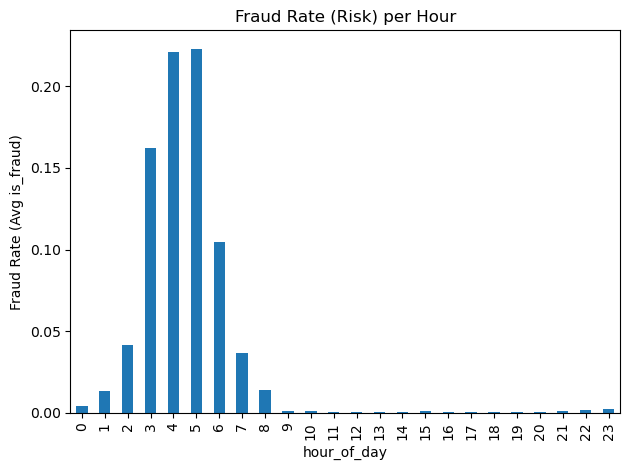

In [10]:
fraud_mock_df['hour_of_day'] = fraud_mock_df['time_ind']%24

fraud_rate_per_day = fraud_mock_df.groupby('hour_of_day')['is_fraud'].mean()
fraud_rate_per_day.plot(kind='bar')

plt.xlabel('hour_of_day')
plt.ylabel('Fraud Rate (Avg is_fraud)') 
plt.title('Fraud Rate (Risk) per Hour') 
plt.tight_layout()
plt.show()

## Relation is_fraud & days

จากกราฟด้านล่าง Plot ความสัมพันธ์ของวัน กับ จำนวนครั้งของการโกง เพื่อดูว่าวันมีผลต่อความถี่ของการโกงหรือไม่??

: ซึ่งจากกราฟจะวิเคราะห์ได้ว่า มีวันที่โดดมาอยู่วันเดียวคือวันที่ 30 ซึ่งมีfraud_rateถึง 1.0

**จึงคิดว่าควรสร้าง Features Day ในการเทรน**

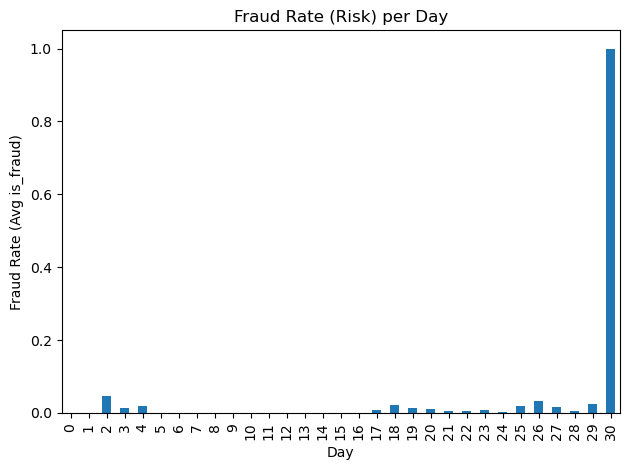

In [11]:
fraud_mock_df['day'] = fraud_mock_df['time_ind']//24

fraud_rate_per_day = fraud_mock_df.groupby('day')['is_fraud'].mean()
fraud_rate_per_day.plot(kind='bar')

plt.xlabel('Day')
plt.ylabel('Fraud Rate (Avg is_fraud)') 
plt.title('Fraud Rate (Risk) per Day') 
plt.tight_layout()
plt.show()

# Features transac_type

### Relation between is_fraud & type of transac_type

เพื่อวิเคราะห์ว่า Transac_type มีผลต่อการโกงหรือไม่?

: โดยเราเลือก plot เป็น bar chart เพื่อให้เห็นความแตกต่างระหว่าง transac_type ได้ว่า transac_type มีผลต่อการโกงซึ่งการโกงจะเกิดใน tranc_type เพียงสองประเภทนั้นก็คือ 'CASH_OUT' and 'TRANSFER'

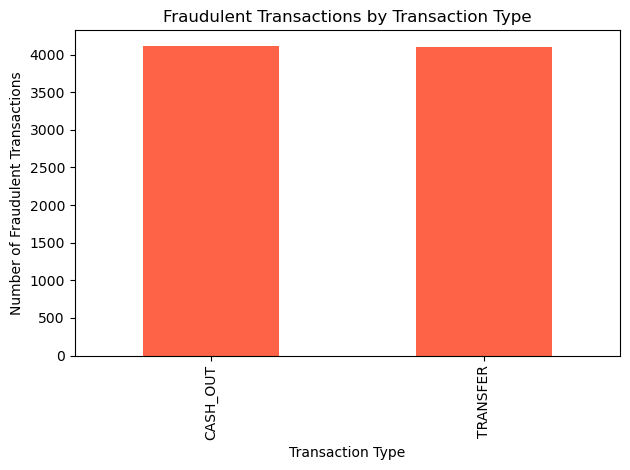

In [12]:
fraud_type_counts = fraud_transactions['transac_type'].value_counts()

fraud_type_counts.plot(kind='bar', color='tomato')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Transaction Type')
plt.tight_layout()
plt.show()

# Features is_fragged_fraud

## Relation between is_fraud & is_flagged_fraud

เพื่อวิเคราะห์ว่า is_fragged_fraud มีการ flagged ได้ถูกต้อง มากน้อยแค่ไหน

: เลือกใช้เป็น Heat Map เพื่อให้เห็นความต่างของค่าแต่ละช่องผ่านความเข้มของสี ซึ่งได้ผลลัพธ์ว่าถ้า is_flagged_fraud==1 จะได้ว่า Account นั้นเป็น fraud แน่นอน แต่ว่าตอนนี้ is_flagged_fraud ตรวจจับได้เพียง 16 คนจากทั้งหมด 8213 คน ( ML เราควรเพิ่ม Recall ให้ตรวจจับโจรได้มากขึ้น )

**ซึ่งเราตัด Feature นี้ออกเนื่องจากถ้าอ้างอิงจากข้อมูล 6 ล้านแถวมีเพียง 16 แถวที่เป็น is_flagged_fraud ==1 มองว่าข้อมูลน้อยมาก จนแทบไม่มีผล**

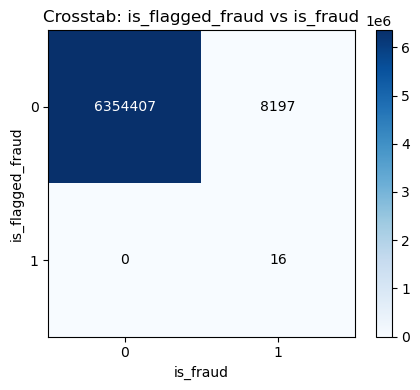

In [13]:
ct = pd.crosstab(fraud_mock_df['is_flagged_fraud'], fraud_mock_df['is_fraud'],
                 rownames=['is_flagged_fraud'], colnames=['is_fraud'])

# heatmap ด้วย matplotlib (ไม่ต้อง import เพิ่ม)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(ct.values, cmap='Blues')
for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        ax.text(j, i, ct.iat[i, j], ha='center', va='center',
                color='white' if ct.iat[i, j] > ct.values.max()/2 else 'black')
ax.set_xticks(range(ct.shape[1])); ax.set_yticks(range(ct.shape[0]))
ax.set_xticklabels(ct.columns); ax.set_yticklabels(ct.index)
ax.set_xlabel('is_fraud'); ax.set_ylabel('is_flagged_fraud')
ax.set_title('Crosstab: is_flagged_fraud vs is_fraud')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Features src_acc & dst_acc Analysis

## src_acc & dst_acc with is_fraud

ดูความสำคัญของ Features src_acc & dst_acc ว่าบัญชีมีการโกงซ้ำๆไหม

: ได้ผลว่าแต่ละบัญชีมีการโกงเฉลี่ยบัญชีละ 1 ครั้ง => คนที่โกงใช้บัญชีใหม่ในการโกงเสมอ ซึ่งจะแบ่งออกเป็นสองแนวทางคือ
1. มองว่าบัญชีไม่มีผลต่อการตัดสินใจในอนาคต + ป้องกัน Data Leaked = ตัด Features src_acc & dst_acc ทิ้งเลย 

**( เลือกใช้วิธีนี้เนื่องจากไม่สามารถเช็คได้ว่าในระบบจริง acc นั้นๆทำ transaction เป็นครั้งแรก จริงหรือไม่ )**

2. มองว่าคนที่โกงจะใช้บัญชีใหม่เสมอ = ทำ Feature ใหม่เป็น is_new_src_acc & is_new_dst_acc

In [14]:
print(f"fraud_times: {len(fraud_transactions)} ครั้ง\n")

# fraud_src_acc
fraud_counts_by_sender = fraud_transactions.groupby('src_acc').size()
avg_fraud_count_per_sender = fraud_counts_by_sender.mean()

print(f"src_acc (Sender)")
print(f"number of fraud_src_acc: {len(fraud_counts_by_sender)} บัญชี")
print(f"เฉลี่ยแล้ว src_acc โกงบัญชีละ: {avg_fraud_count_per_sender:.2f} ครั้ง")


# fraud_dst_acc
fraud_counts_by_receiver = fraud_transactions.groupby('dst_acc').size()
avg_fraud_count_per_receiver = fraud_counts_by_receiver.mean()

print(f"\ndst_acc (Reciever)")
print(f"number of fraud_dst_acc: {len(fraud_counts_by_receiver)} บัญชี")
print(f"เฉลี่ยแล้ว dst_acc โกงบัญชีละ: {avg_fraud_count_per_receiver:.2f} ครั้ง")

fraud_times: 8213 ครั้ง

src_acc (Sender)
number of fraud_src_acc: 8213 บัญชี
เฉลี่ยแล้ว src_acc โกงบัญชีละ: 1.00 ครั้ง

dst_acc (Reciever)
number of fraud_dst_acc: 8169 บัญชี
เฉลี่ยแล้ว dst_acc โกงบัญชีละ: 1.01 ครั้ง


# Features src_bal & dst_bal

## Relation Overview

In [27]:
fraud_mock_df['src_change'] = fraud_mock_df['src_new_bal'] - fraud_mock_df['src_bal']
fraud_mock_df['dst_change'] = fraud_mock_df['dst_new_bal'] - fraud_mock_df['dst_bal']

fraud_mock_df['src_ratio'] = fraud_mock_df['src_change'] / (fraud_mock_df['src_bal'] + 1)
fraud_mock_df['dst_ratio'] = fraud_mock_df['dst_change'] / (fraud_mock_df['dst_bal'] + 1)
fraud_transactions = fraud_mock_df[fraud_mock_df['is_fraud']==1]

cols = ['amount','src_bal','src_new_bal','dst_bal','dst_new_bal','src_change','dst_change','src_ratio','dst_ratio']

fraud_transactions[cols].describe()

,amount,src_bal,src_new_bal,dst_bal,dst_new_bal,src_change,dst_change,src_ratio,dst_ratio
count,8213.00,8213.00,8213.00,8213.00,8213.00,8213.00,8213.00,8213.00,8213.00
mean,1467967.30,1649667.61,192392.63,544249.62,1279707.62,-1457274.97,735458.00,-0.99,233497.39
std,2404252.95,3547719.44,1965666.46,3336420.95,3908816.53,2396099.20,1856983.86,0.10,1118098.70
min,0.00,0.00,0.00,0.00,0.00,-10000000.00,-315226.07,-1.00,-1.00
25%,127091.33,125822.44,0.00,0.00,0.00,-1503034.86,0.00,-1.00,0.00
50%,441423.44,438983.45,0.00,0.00,4676.42,-436317.49,0.00,-1.00,0.00
75%,1517771.48,1517771.48,0.00,147828.66,1058725.22,-124582.58,445257.43,-1.00,4.74
max,10000000.00,59585040.37,49585040.37,236230516.82,236726494.66,0.00,14915111.47,0.00,10000000.00


นำค่า Features: ['amount','src_bal','src_new_bal','dst_bal','dst_new_bal','src_change','dst_change','src_ratio','dst_ratio'] มาลองคำนวนเพื่อทำ features ใหม่ ละทำการplot Heat map เพื่อหหาค่า Correlation ระหว่างตัวแปรประเภทคล้ายๆกัน

: พบว่า
1. (src_bal & src_new_bal) และ (dst_bal & dst_new_bal) ทั้งสองคู่นี้มีค่าที่ค่อนข้าง Correlate กันมากเราจึงเลือกที่จะตัด Features ใด Features หนึ่งออก โดยเราเลือกตัด Columns: src_new_bal, dst_new_bal เนื่องจากมองว่า Features ดังกล่าวเป็นเหมือน Features ที่เป็นผลลัพธ์หลัง Transaction ซึ่งอาจทำให้ค่าที่เกิดขึ้นเป็นค่าที่ออิงกับผลลัพธ์ หรือ Target ของเราแล้ว

**เลือกใช้ Features src_bal,dst_bal และตัด Columns src_new_bal,dst_new_bal ทิ้ง**

2. src_change,dst_change,src_ratio,dst_ratio - โดยเราคิดว่าควรเลือกใช้เป็น Ratio มากกว่าที่จะเป็นค่า Change เนื่องจากแต่ละ transaction ควรจะเป็นการเปรียบเทียบกับของเดิมที่มีอยู่ เพื่อให้เห็นขนาดของ transaction นั้นจริง

**เลือกใช้ Features src_ratio,dst_ratio เพิ่มเติม**

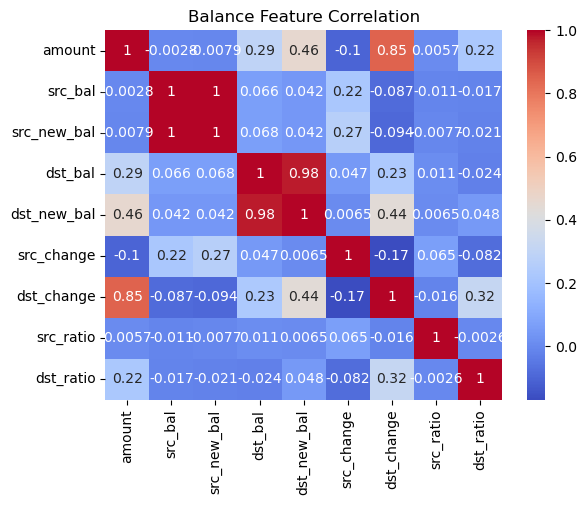

In [28]:
sns.heatmap(fraud_mock_df[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Balance Feature Correlation")
plt.show()